In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats, os
from tqdm import tqdm
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from numpy.linalg import matrix_rank
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False
from libsvm.svmutil import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def one_hot_representer(labels):
    count = np.unique(labels).shape[0]
    temp = np.zeros((labels.shape[0], count), dtype = int)
    for index, i in np.ndenumerate(labels):
        temp[index,i] = 1
    return temp

# MODEL Classes

### GMM

In [212]:
class GMM:
    def __init__(self,data,k,plotting = False, iterations = 100):
        self.k = k
        self.pi = np.ones(k) / k
        mu,sigma = self.KMeans(data,k)
        self.pi, self.normals = self.fit(data,self.pi,mu,sigma, plotting, iterations)
    
    def KMeans(self, data,k, eps = 1e-6):
        from numpy.linalg import norm
        np.random.shuffle(data)
        mu = data[:k,:]
        error = [1]*k
        while np.max(error) > eps:
            error = 0
            compare = np.array([norm(data-mu[i], axis = 1) for i in range(k)])
            result = np.argmin(compare, axis=0)
            newmu = np.array([np.mean(data[result == i], axis=0) for i in range(k)])
            error = norm(newmu - mu, axis= 1)
            mu = newmu
        cov = []
        for i in range(k):
            d = data[result == i]
            cov.append( np.cov(d.T) )
        return mu, cov

    def fit(self,data,pi,mu,sigma, plotting = False, iterations = 100):
        N,D = data.shape
        k = self.k
        sigma_0 = np.zeros((k,D,D))
        for i in range(k):
            temp = sigma[i]
            while matrix_rank(temp) < D:
                temp += np.identity(D) * 1e-3
            for i in range(k):
                sigma_0[i] = temp

        sigma = np.array(sigma_0)
        normals = [multivariate_normal(mean=mu[i], cov = sigma[i]) for i in range(k)]    
        prob_xn = np.array([[normals[j].logpdf(each) for j in range(k)] for each in data])
        pi = np.log(pi)
        log_liklihood =  np.sum(logsumexp(prob_xn + pi, axis = 1))
        diff = 1000
        liklihood_track = [log_liklihood]
        responsibility = np.zeros((N,D))
        diff = 100
        
        def E_step():
            nonlocal responsibility
            t = prob_xn + pi
            d = logsumexp(t,axis = 1, keepdims = True)
            responsibility = t - d

        def M_step():
            nonlocal mu, sigma, pi, normals
            Nk = logsumexp(responsibility,axis = 0)
            temp = responsibility - Nk
            for i in range(k):
                mu[i] = np.average(data, axis = 0, weights=np.exp(responsibility[:,i]))
                sigma[i] *= 0
                t = data - mu[i]
                tt = t.T
                for n in range(N):
                    tcov = tt[:,n] @ t[n,:]
                    sigma[i] += np.exp(temp[n,i]) * tcov
                if (matrix_rank(sigma[i]) < D):
                    sigma[i] = sigma_0[i]
                normals[i] = multivariate_normal(mean=mu[i], cov = sigma[i])
            pi = Nk - np.log(N)

        def prob_giver():
            nonlocal normals, data
            p = np.array([[normals[c].logpdf(xn) for c in range(k)] for xn in data])
            p = np.argmax(p, axis = 1)
            return p
    
        def liklihood_update():
            nonlocal log_liklihood, diff, liklihood_track,prob_xn,diff,pi,sigma,mu
            prob_xn = np.array([[normals[j].logpdf(each) for j in range(k)] for each in data])
            temp = np.sum(logsumexp(prob_xn + pi, axis = 1))

            diff = temp - log_liklihood 
            log_liklihood = temp
            liklihood_track.append(log_liklihood)
        
        b = 0
        while b < iterations:
            b +=1
            E_step()       
            M_step()
            liklihood_update()
            if diff < 10e-6:
                break
        if plotting:
            plt.plot(liklihood_track, 'r-')
            plt.yscale("symlog")
            plt.show()
        return pi, normals
    
    def log_probablity(self,X):
        result = []
        for each in X:
            p = []
            for i in range(self.k):
                p.append(self.normals[i].logpdf(each) + self.pi[i])
            result.append(logsumexp(p))
        result = np.array(result)
        return result
    
    def predict(self,X):
        result = []
        for each in X:
            p = []
            for i in range(self.k):
                p.append(self.normals[i].logpdf(each) + self.pi[i])
            result.append(np.array(p))
        result = np.array(result)
        return np.argmax(result,axis = 1)

## Fisher LDM

In [4]:
class fisher_LDM:

    def __init__(self, train_data, train_label):
    
        class_0 = train_data[train_label == 0]
        class_1 = train_data[train_label == 1]

        mean0 = np.mean(class_0, axis=0)
        mean1 = np.mean(class_1, axis=0)

        centered_class_0 = class_0 - mean0[np.newaxis,:]
        centered_class_1 = class_1 - mean1[np.newaxis,:]
        within_class_cov = np.cov(np.vstack((centered_class_0,centered_class_1)).T)
        
        from numpy.linalg import matrix_rank, inv

        while matrix_rank(within_class_cov) < within_class_cov.shape[0]:
            within_class_cov += np.identity(within_class_cov.shape[0]) + 10e-5
        
        w = inv(within_class_cov) @ (mean0 - mean1).reshape(-1,1)
        w = w.flatten()
        self.w = w / np.sum(w)

        x = np.dot(mean0,self.w)
        y = np.dot(mean1,self.w)
        if x > y:
            self.first_class = 0
            self.second_class = 1
        else:
            self.first_class = 1
            self.second_class = 0
        self.threshold = (class_1.shape[0] * x + class_0.shape[0] * y)/train_data.shape[0]
    
    def predict(self,X):
        t = (X @ self.w).flatten()
        
        for i, each in enumerate(t):
            if each > self.threshold:
                t[i] = self.first_class
            else:
                t[i] = self.second_class
        
        return t

## SVM Mode

In [42]:
class svm_model:
    
    def __poly_kernal(x, y, **kwarg):
        temp = np.dot(x, y)
        return (kwarg["gamma"] * temp)**kwarg["degree"]

    def __gaussian_kernal(x, y, **kwarg):
        temp = x - y 
        return np.exp(- kwarg["gamma"] * np.dot(temp,temp))
    
    def __linear_kernel(x,y,**kwarg):
        return np.dot(x,y)

    kernals = {"gaussian": __gaussian_kernal, "poly_kernal" : __poly_kernal, \
        "linear": __linear_kernel}


    def __init__(self, data_, label_ ,slack, kernal ,**kwarg):
        self.scaler = StandardScaler()
        label = label_.astype(float)
        data = data_.astype(float)
        data = self.scaler.fit_transform(data)
        label[label==0] = -1
        self.kernal = self.kernals[kernal]
        self.extra_info = kwarg
        N,D = data.shape
        P = np.zeros((N,N), dtype=float)
        for i in range(N):
            for j in range(N):
                P[i,j] = self.kernal(data[i], data[j], **kwarg)

        mu, self.b = self.SMO(data, label,P, slack)

        # print(np.min(mu), np.max(mu))
        # self.threshold = min(1e-3, np.mean(mu))
        self.threshold = 1e-4
        supoort_indices = (mu > self.threshold).flatten()
        self.sp_vector = data[supoort_indices]
        self.sp_label = label[supoort_indices]
        self.mu = mu[supoort_indices]
        n = self.n = self.sp_vector.shape[0]
        print("my #support vector: ",n)

    def SMO(self, X, Y, P, C , max_iterations = 1, tolerance=1e-3):
        N, D = X.shape
        mu = np.zeros_like(Y)
        b = 0        
        itercount = 0
        
        def predict(j):
            temp = 0
            for i in range(N):
                temp += mu[i] * Y[i] * P[i,j]
            return temp + b

        while (itercount < max_iterations):
            change = 0  # did mu change
            for i in range(N):
                Ei = predict(i) - Y[i]

                if(Y[i] * Ei < -tolerance and mu[i] < C) or (Y[i] * Ei > tolerance and mu[i] > 0):

                    j = 0
                    while(j==i):
                        j = np.random.randint(0,N)

                    Ej = predict(j) - Y[j]
                    old_mui, old_muj = mu[i], mu[j]

                    L,H = max(0, old_muj - old_mui), min(C, C + old_muj - old_mui)
                    if Y[i] == Y[j]:
                        L = max(0, old_mui + old_muj - C)
                        H = min(C, old_mui + old_muj)
                    
                    if abs(L-H) < 10e-5:
                        continue
                    
                    ita = 2 * P[i,j] - P[i,i] - P[j,j]
                    
                    if ita >= 0 :
                        continue
                        
                    muj = old_muj - (Y[j] * (Ei - Ej) / ita)
                    muj = min(H,muj)
                    muj = max(L,muj)
    
                    if abs(muj - old_muj) < 10e-5:
                        continue

                    mu[j] = muj
                    mui = old_mui + Y[i] * Y[j] * (old_muj - muj)
                    mu[i] = mui

                    temp1 = mui - old_mui
                    temp2 = muj - old_muj
                    b1 = b - Ei - Y[i] * temp1 * P[i,i] - Y[j] * temp2 * P[i,j]
                    b2 = b - Ej - Y[i] * temp1 * P[i,j] - Y[j] * temp2 * P[j,j]

                    if 0 < mui < C:
                        b = b1
                    elif 0 < muj < C:
                        b = b2
                    else:
                        b = (b1+b2)/2
                    change += 1
            
            if not change:
                itercount += 1
            else:
                itercount = 0
        return mu, b
                 
    def predict(self, X):

        X = self.scaler.transform(X)
        predictions = []
        for i, each in enumerate(X):
            temp = 0
            for i in range(self.n):
                temp += self.mu[i] * self.sp_label[i] * \
                    self.kernal(self.sp_vector[i], each, **self.extra_info)
            temp += self.b
            temp = np.sign(temp)
            temp = 1 if temp > 0 else 0
            predictions.append(temp)
        return np.array(predictions)

In [93]:
from sklearn.svm import SVC
class grid_search_svm:
    def __init__(self, train_data, train_label, test_data, test_label, acc_function):
        self.train_data = train_data
        self.train_label = train_label
        self.test_data = test_data
        self.test_label = test_label   
        self.acc_function = acc_function 
    
    def gaussian(self, gamma= [], slack=[]):
        for i in slack:
            for each in gamma:
                m = SVC(C = i, kernel = "rbf", gamma = each, probability = True)
                m.fit(self.train_data, self.train_label)
                y_ = m.predict_proba(self.test_data)
                print("RBF: slack({}) gamma({}) mectrics:".format(i, each), end="")
                self.acc_function(self.test_label,y_, printing = True)
                print("-"*20)
    
    def polynomial(self, degree = [], slack = []):
        for i in slack:
            for each in degree:
                m = SVC(C = i, kernel = "poly", degree = each, probability = True)
                m.fit(self.train_data, self.train_label)
                y_ = m.predict_proba(self.test_data)
                print("RBF: slack({}) degree({}) mectrics:".format(i, each), end="")
                self.acc_function(self.test_label,y_, printing = True)
                print("-"*20)

    def linear(self, slack = []):
        for i in slack:
            m = SVC(C = i, kernel = "linear", probability = True)
            m.fit(self.train_data, self.train_label)
            y_ = m.predict_proba(self.test_data)
            print("RBF: slack({}) mectrics:".format(i), end="")
            self.acc_function(self.test_label,y_, printing = True)
            print("-"*20)

## Multi layer Perceptron

In [149]:
class MLP:
    def __init__(self, inputs, targets, epochs = 1, learning_rate = 0.01 ,num_inputs = 0, \
        hidden_layers=[12, 12], num_outputs=1, \
        hidden_activation = "relu", output_activation = "softmax", loss_function = "mse"):

        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.loss_function = loss_function
        layers = [num_inputs] + hidden_layers + [num_outputs]

        weights = []
        for i in range(len(layers) - 1):
            w = np.random.rand(layers[i], layers[i + 1]) * np.sqrt(2 / layers[i + 1])
            weights.append(w)
        self.weights = weights

        net_inputs = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i + 1]))
            net_inputs.append(d)
        self.net_inputs = net_inputs

        activations = []
        for i in range(len(layers)):
            a = np.zeros(layers[i])
            activations.append(a)
        self.activations = activations

        delta_error = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i + 1]))
            delta_error.append(d)
        self.delta_error = delta_error

        self.train(inputs, targets,epochs,learning_rate)


    def forward_propagate(self, inputs):
        activations = inputs
        self.activations[0] = activations
        for i, w in enumerate(self.weights):
            net_inputs = (activations.reshape(1,-1) @ w).flatten()
            self.net_inputs[i] = net_inputs

            if self.hidden_activation == "sigmoid": 
                activations = self._sigmoid(net_inputs)
            elif self.hidden_activation == "relu":
                activations = self._relu(net_inputs)
            elif self.hidden_activation == "softmax":
                activations = self._softmax(net_inputs)

            self.activations[i + 1] = activations
        
        if self.output_activation == "softmax":
            self.activations[-1] = self._softmax(self.activations[-1])
        elif self.output_activation == "sigmoid":
            self.activations[-1] = self._sigmoid(self.activations[-1])
        elif self.output_activation == "relu":
            self.activations[-1] = self._relu(self.activations[-1])
             
        return self.activations[-1]


    def back_propagate(self):
        for i in reversed(range(len(self.delta_error)- 1)):
            activations = self.activations[i+1]

            if self.hidden_activation == "sigmoid": 
                derivatives = self._sigmoid_derivative(activations)
            elif self.hidden_activation == "relu":
                # activations[activations <= 0] = 0
                derivatives = self._relu_derivative(activations)
            elif self.hidden_activation == "softmax":
                t = self.net_inputs[i]
                derivatives = self._sigmoid_derivative(self._sigmoid(t))
            derivatives = derivatives.flatten()
            self.delta_error[i] = (self.weights[i+1] @ self.delta_error[i+1].reshape(-1,1)).flatten() * derivatives


    def train(self, inputs, targets, epochs, learning_rate):
        for i in range(epochs):
            sum_errors = 0
            for j, input in enumerate(inputs):
                target = targets[j]
                output = self.forward_propagate(input)
                if self.loss_function == "squared_loss":
                    error = self._mse_derivative(target, output) 
                elif self.loss_function == "cross_entropy_loss":
                    error = self._CE_derivative(target, output)

                if self.output_activation == "sigmoid": 
                    derivatives = self._sigmoid_derivative(output)
                elif self.output_activation == "relu":
                    derivatives = self._relu_derivative(output)
                elif self.output_activation == "softmax":
                    t = self.net_inputs[-1]
                    derivatives = self._sigmoid_derivative(self._sigmoid(t))
                
                self.delta_error[-1] = error * derivatives
                self.back_propagate()
                self.gradient_descent(learning_rate)

                if self.loss_function == "squared_loss":
                    sum_errors += self._mse(target, output)
                elif self.loss_function == "cross_entropy_loss":
                    sum_errors += self._CE(target, output)
            
            # if( i % 25 == 0):

        # print("Error: {}".format(sum_errors / inputs.shape[0]))
        # print("Training complete!")
    
    def predict(self, x):
        result = []
        for each in x:
            predicted = self.forward_propagate(each)
            result.append(predicted)
        return np.array(result)


    def gradient_descent(self, learningRate=1):
        for i in range(len(self.weights)):
            weights = self.weights[i]
            activations = self.activations[i]
            delta_error = self.delta_error[i]
            temp = activations.reshape(-1,1) @ delta_error.reshape(1,-1)
            weights -= temp * learningRate


    def _sigmoid(self, x):
        y = scipy.special.expit(x)
        return y

    def _sigmoid_derivative(self, x):
        return x * (1.0 - x)
    
    def _relu(self, x_):
        x = x_[:]
        x[x < 0] = 0.0
        return x

    def _relu_derivative(self,x):
        y = np.zeros_like(x, dtype=float)
        y[x>0] = 1.0
        return y

    def _CE(self, target, output_):
        ce = -np.sum(target*np.log(output_+1e-9))
        return ce

    def _softmax(self,x_):
        x = x_ / (np.max(x_) + 1e-9)
        exp = np.exp(x - np.max(x))
        return exp / (np.sum(exp) + 1e-9)

    def _mse(self, target, output):
        return np.sum((target - output) ** 2)

    def _mse_derivative(self, target, output):
        return target - output
    
    def _CE_derivative(self, target, output):
        return - target / (output + 1e-9)

## Bayes Classifier with MLE

In [32]:
class Bayes_classifier_ML:
    
    def __init__(self, data, labels):
        self.gaussian = []
        self.classes = np.unique(labels).shape[0]
        N = data.shape[0]
        prior = []
        for i in range(self.classes):
            tdata = data[labels == i]
            mean = np.mean(tdata, axis=0)
            cov = np.cov(tdata.T)
            self.gaussian.append(multivariate_normal(mean=mean, cov = cov, allow_singular=True))
            prior.append(tdata.shape[0]/N)
        self.prior = np.log(np.array(prior))
    
    def predict(self,x):
        result = []
        for each in x:
            posterior = []
            for i in range(self.classes):
                posterior.append(self.gaussian[i].logpdf(each) + self.prior[i])
            result.append(scipy.special.softmax(posterior))
        return np.array(result)


## Parzen 

In [9]:
class Bayes_classifier_Parzen:
    def __init__(self,data,label,L):  # L is the length of hypercube
        self.classes = np.unique(data).shape[0]
        self.data = data
        self.label = label
        self.L = L
    
    def predict(self,x):
        result = []
        for each in x:
            temp = np.abs(self.data - each) <= (self.L/2)
            temp = np.bitwise_and.reduce(temp, axis=1)
            temp = self.label[temp]
            a,b = np.unique(temp, return_counts=True)
            result.append( scipy.special.softmax(b) )
        return np.array(result)

## Linear Models

In [10]:
class linear_regression:
    def __init__(self,Data,labels, learning_rate = 0.01, batch_size = 32,epochs = 20):
        data = np.c_[Data, np.ones((Data.shape[0],1))]
        w = np.random.rand(data.shape[1])
        self.w = self.learn(data,labels,w, learning_rate,batch_size, epochs)

    def learn(self,data,labels,w, learning_rate, batch_size,epochs):
        N = data.shape[0]
        for _ in range(epochs):
            shfl = np.random.permutation(N)
            data = data[shfl]
            labels = labels[shfl]
            for start in range(0, N, batch_size):
                a,b = start, min(start + batch_size, N)
                d = data[a:b,:]
                predictions = (d @ w.reshape(-1,1)).flatten()
                error = predictions - labels[a:b]
                grad = np.mean(d * error[:,np.newaxis], axis = 0)
                w = w - learning_rate * grad
        return w
    
    def predict(self,x):
        result = np.c_[x,np.ones((x.shape[0],1))] @ self.w.reshape(-1,1)
        return result.flatten()

In [11]:
class linear_regression:
    def __init__(self,Data,labels, regulariser_value = (0,0), learning_rate = 0.01, batch_size = 32,epochs = 20):
        data = np.c_[Data, np.ones((Data.shape[0],1))]
        w = np.random.rand(data.shape[1])
        self.w = self.learn(data,labels,regulariser_value, w, learning_rate,batch_size, epochs)

    def learn(self,data,labels,regulariser_value,w, learning_rate, batch_size,epochs):
        N = data.shape[0]
        for _ in range(epochs):
            shfl = np.random.permutation(N)
            data = data[shfl]
            labels = labels[shfl]
            for start in range(0, N, batch_size):
                a,b = start, min(start + batch_size, N)
                d = data[a:b,:]
                predictions = (d @ w.reshape(-1,1)).flatten()
                error = predictions - labels[a:b]
                grad = np.mean(d * error[:,np.newaxis] ,axis = 0)
                if regulariser_value[0]:
                    t = np.sign(w)
                    t[t == 0] = 1e-5
                    grad = grad + regulariser_value[0] * t
                elif regulariser_value[1]:
                    grad = grad + regulariser_value[1] * w

                w = w - learning_rate * grad
        return w
    
    def predict(self,x):
        result = np.c_[x,np.ones((x.shape[0],1))] @ self.w.reshape(-1,1)
        return result.flatten()

In [12]:
class linear_classifier:
    def __init__(self,Data,labels,regulariser_value = (0,0), learning_rate=0.1, batch_size = 32,epochs = 20):
        self.regression = linear_regression(Data,labels,regulariser_value,learning_rate=learning_rate,\
            batch_size = batch_size,epochs = epochs)
    
    def predict(self,x):
        result = self.regression.predict(x)
        return result > 0.5


In [13]:
class logistic_regression:
    def __init__(self, Data, labels, regulariser_value = (0,0), learning_rate = 0.01, batch_size = 32,epochs = 20):
        data = np.c_[Data, np.ones((Data.shape[0],1))]
        w = np.random.rand(data.shape[1])
        self.w = self.learn(data,labels,regulariser_value,w, learning_rate,batch_size, epochs)

    def learn(self,data,labels,regulariser_value, w, learning_rate, batch_size,epochs):
        N = data.shape[0]
        for _ in range(epochs):
            shfl = np.random.permutation(N)
            data = data[shfl]
            labels = labels[shfl]
            for start in range(0, N, batch_size):
                a,b = start, min(start + batch_size, N)
                d = data[a:b,:]
                predictions = scipy.special.expit(d @ w.reshape(-1,1).flatten())
                error = predictions - labels[a:b]
                grad = np.sum(d * error[:,np.newaxis], axis = 0)
                if regulariser_value[0]:
                    t = np.sign(w)
                    t[t == 0] = 1e-5
                    grad = grad + regulariser_value[0] * t
                elif regulariser_value[1]:
                    grad = grad + regulariser_value[1] * w
                w = w - learning_rate * grad
        return w
    
    def predict(self,x):
        result = scipy.special.expit(np.c_[x,np.ones((x.shape[0],1))] @ self.w.reshape(-1,1))
        return result.flatten()

In [14]:
class logistic_classifier:
    def __init__(self,Data,labels, regulariser_value = (0,0), learning_rate=0.1, batch_size = 32,epochs = 20):
        self.regression = logistic_regression(Data,labels,regulariser_value,learning_rate=learning_rate,\
            batch_size = batch_size,epochs = epochs)
    
    def predict(self,x):
        result = self.regression.predict(x)
        return result > 0.5


In [15]:
class linear_regression_poly:
    def __init__(self,data,label,degree):
        N = data.shape[0]
        X = np.zeros((N,N),dtype=float)
        for i in range(N):
            for j in range(N):
                X[i,j] = self.kernal(data[i,:],data[j,:],degree)
        
        X = np.linalg.inv(X)
        alpha = X @ label.reshape(-1,1)
        self.w = data.T @ alpha
        
    def kernal(self, x, y, d):
        return np.dot(x, y) ** d

    def predict(self,x):
        result = x @ self.w.reshape(-1,1)
        return result.flatten()      

In [16]:
class linear_regression_poly_classifier:
    def __init__(self, data, label, degree):
        self.poly_regressor = linear_regression_poly(data,label,degree)
    
    def predict(self,x):
        result = self.poly_regressor.predict(x)
        return result > 0.5

## KNN

In [29]:
class KNN:
    def __init__(self,data,label,k):  
        self.classes = np.unique(label).shape[0]
        self.data = data
        self.label = label
        self.k = k
    
    def predict(self,x):
        result = []
        for each in x:
            temp = np.linalg.norm(self.data - each, axis=1)
            temp = np.argsort(temp)
            temp = self.label[temp][:self.k]
            a,b = np.unique(temp,return_counts=True )
            probab = np.zeros(self.classes)
            probab[a] = b / self.k
            result.append(probab)
        return np.array(result)

## Multi class models

In [18]:
class NeiveBayesModel:
    def __init__(self, DATA, labels, bins = 256):
        self.bins = bins+1
        self.N , self.D = DATA.shape
        self.classes = np.unique(labels)
        self.extra = list(range(bins))
        self.data = [DATA[labels == c] for c in self.classes]
        self.distriubtion_array = [self.__helper1(i) for i in self.classes]
        self.prior = np.log(np.array([each.shape[0] for each in self.data])/self.N)
        del(self.data)
        del(self.extra)
    
    def __helper1(self, c):
        import scipy.stats
        histograms = []
        for i in range(self.D):
            feature_data = self.data[c][:,i].tolist() + self.extra
            hist = np.histogram(feature_data, bins = np.arange(self.bins))
            hist_dist = scipy.stats.rv_histogram(hist)
            histograms.append(hist_dist)
        return histograms
    
    def predict(self,X):
        results = []
        for each in X:
            probablities = []
            for c in self.classes:
                p = 0
                for d in range(self.D):
                    p += self.distriubtion_array[c][d].logpdf(each[d])
                p += self.prior[c]
                probablities.append(p)
            t = np.array(probablities)
            t = scipy.special.softmax(t)
            results.append(t)
        return np.array(results)

In [19]:
class multi_class_linear_classifier:
    def __init__(self,Data,labels, regulariser_value = (0,0),learning_rate=0.1, batch_size = 32,epochs = 20):
        num_func = np.unique(labels).shape[0]
        self.regressor = []
        for i in range(num_func):
            y = labels == i
            self.regressor.append(linear_regression(Data, y, regulariser_value ,learning_rate, batch_size, epochs))
    
    def predict(self,x):
        result = []
        for regrssor in self.regressor:
            result.append(regrssor.predict(x))
        result = np.array(result).T
        return scipy.special.softmax(result, axis = 1)

In [20]:
class multi_class_logistic_classifier:
    def __init__(self,Data,labels, regulariser_value = (0,0),learning_rate=0.1, batch_size = 32,epochs = 20):
        num_func = np.unique(labels).shape[0]
        self.regressor = []
        for i in range(num_func):
            y = labels == i
            self.regressor.append(logistic_regression(Data, y, regulariser_value,learning_rate, batch_size, epochs))
    
    def predict(self,x):
        result = []
        for regrssor in self.regressor:
            result.append(regrssor.predict(x))
        result = np.array(result).T
        return scipy.special.softmax(result, axis = 1)

In [21]:
class multi_fisher_LDM:
    def __init__(self, data, label):
        label = one_hot_representer(label)
        self.ldm = []
        for each in range(label.shape[1]):
            self.ldm.append(fisher_LDM(data,label[:,each]))
    
    def predict(self,x):
        result = []
        for each in self.ldm:
            result.append(each.predict(x))
        result = scipy.special.softmax(np.array(result).T, axis = 1)
        return result

In [76]:
class multi_class_svm:
    def __init__(self,Data,labels, slack = 1, kernal = "gaussian", gamma = 1, degree = 1):
        num_func = np.unique(labels).shape[0]
        self.regressor = []
        for i in range(num_func):
            y = labels == i
            self.regressor.append(svm_model(Data, y,slack = slack, kernal = kernal , gamma = gamma, degree = degree))
    
    def predict(self,x):
        result = []
        for regrssor in self.regressor:
            result.append(regrssor.predict(x))
        result = np.array(result).T
        return scipy.special.softmax(result, axis = 1)

In [266]:
def plot_graph(x_name, x,accuracy, aread_under_curve, f1_score):
    x_axis = np.arange(len(x))
    width = 0.2
    plt.bar(x_axis-0.2, accuracy, width, color='red')
    plt.bar(x_axis, aread_under_curve, width, color='blue')
    plt.bar(x_axis+0.2, f1_score, width, color='green')
    plt.xlabel(x_name)
    plt.ylabel("Scores")
    plt.xticks(x_axis, x)
    plt.legend(["Accuracy", "AOC", "F1 score"])
    plt.show()

In [23]:
class vector_valued_linear_regression:
    def __init__(self,Data,labels, regulariser_value = (0,0),learning_rate=0.1, batch_size = 128,epochs = 20):
        num_func = labels.shape[1]
        self.regressor = []
        for i in range(num_func):
            self.regressor.append(linear_regression(Data, labels[:,i], regulariser_value ,learning_rate, batch_size, epochs))
    
    def predict(self,x):
        result = []
        for regrssor in self.regressor:
            result.append(regrssor.predict(x))
        result = np.array(result).T
        return result

# Dataset One

In [3]:
test_images = np.load('../PRNN_data/data_set_1/test_images.npy')
test_labels = np.load('../PRNN_data/data_set_1/test_labels.npy').flatten()
train_images = np.load('../PRNN_data/data_set_1/train_images.npy')
train_labels = np.load('../PRNN_data/data_set_1/train_labels.npy').flatten()
val_images = np.load('../PRNN_data/data_set_1/val_images.npy')
val_labels = np.load('../PRNN_data/data_set_1/val_labels.npy').flatten()

l = [train_images,train_labels,\
    val_images,val_labels,\
    test_images,test_labels]
for i in range(len(l)):
    k = l[i]
    print (k.shape)
del(l)

train_images = train_images.reshape(-1,28*28)
test_images = test_images.reshape(-1,28*28)
val_images = val_images.reshape(-1,28*28)

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import f1_score as f1
def ab_metrics(true_y, predicted_y,printing = True):
    if predicted_y.ndim > 1:
        temp = np.argmax(predicted_y, axis=1)
        temp2 = one_hot_representer(true_y)
        a1 = acc(true_y, temp,normalize=True)
        a2 = auc(temp2, predicted_y, multi_class = 'ovr')
        a3 = f1(true_y, temp,average = 'weighted')
    else:
        a1=acc(true_y, predicted_y,normalize=True)
        a2=auc(true_y, predicted_y)
        a3=f1(true_y, predicted_y)
    if printing:
        print("Accuracy score: {:.3f}".format(a1))
        print("AUC score: {:.3f}".format(a2))
        print("F1 score: {:.3f}".format(a3))
    return a1, a2, a3

(4708, 28, 28)
(4708,)
(524, 28, 28)
(524,)
(624, 28, 28)
(624,)


Doing Dimentionality Reduction and scaling

In [346]:
from sklearn.decomposition import PCA
X = np.vstack((train_images,val_images))
Y = np.concatenate((train_labels,val_labels), axis = 0)

pca = PCA(100)
X = pca.fit_transform(X)
X_ = pca.transform(test_images)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

## Linear

Poly Kernal with degree 2

In [301]:
model = linear_regression_poly_classifier( X,Y,2)
probabilities = model.predict(X_)
ab_metrics(Y_,probabilities)

Accuracy score: 0.492
AUC score: 0.477
F1 score: 0.569


(0.49198717948717946, 0.4773504273504273, 0.5687074829931973)

In [302]:
model = linear_classifier( X,Y, learning_rate = 0.001, epochs = 50)
y_ = model.predict(X_)
ab_metrics(Y_,y_)
# accuracy, aread_under_curve, F1 score

Accuracy score: 0.841
AUC score: 0.793
F1 score: 0.886


(0.8413461538461539, 0.7927350427350428, 0.8860759493670887)

L1

Accuracy score: 0.843
AUC score: 0.795
F1 score: 0.887
Accuracy score: 0.840
AUC score: 0.791
F1 score: 0.885
Accuracy score: 0.829
AUC score: 0.778
F1 score: 0.877
Accuracy score: 0.822
AUC score: 0.788
F1 score: 0.866
Accuracy score: 0.375
AUC score: 0.500
F1 score: 0.000
Accuracy score: 0.375
AUC score: 0.500
F1 score: 0.000


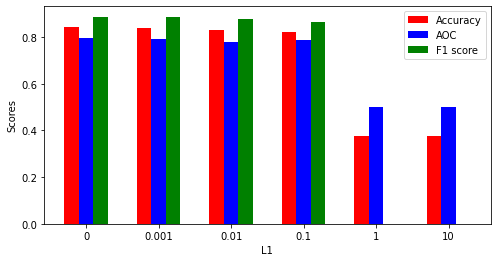

In [303]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = linear_classifier( X,Y, (L1,0),learning_rate = 0.001, epochs = 50)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L1", x,accuracy, aread_under_curve, f1_score)

L2

Accuracy score: 0.825
AUC score: 0.775
F1 score: 0.875
Accuracy score: 0.843
AUC score: 0.792
F1 score: 0.888
Accuracy score: 0.832
AUC score: 0.783
F1 score: 0.879
Accuracy score: 0.811
AUC score: 0.756
F1 score: 0.866
Accuracy score: 0.611
AUC score: 0.665
F1 score: 0.589
Accuracy score: 0.377
AUC score: 0.500
F1 score: 0.010


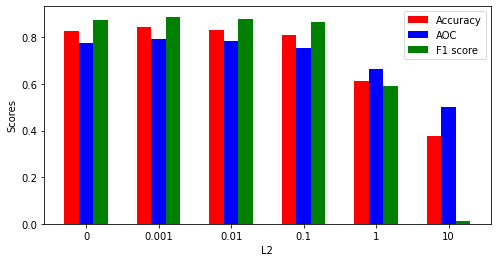

In [304]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = linear_classifier( X,Y, (0,L2),learning_rate = 0.1, epochs = 10)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)
plot_graph("L2", x,accuracy, aread_under_curve, f1_score)

elasticnet

In [347]:
accuracy = []
aread_under_curve = []
f1_score = []
x = []
for L1 in [0.01,0.1,1,5]:
    for L2 in [0.01,0.1,1,5]:
        print("------L1:{} , L2:{}-----".format(L1,L2))
        model = multi_class_linear_classifier( X,Y, (L1,L2),learning_rate = 0.1, epochs = 10)
        y_ = model.predict(X_)
        a,b,c = ab_metrics(Y_,y_)
        accuracy.append(a)
        aread_under_curve.append(b)
        f1_score.append(c)

------L1:0.01 , L2:0.01-----
Accuracy score: 0.841
AUC score: 0.902
F1 score: 0.832
------L1:0.01 , L2:0.1-----
Accuracy score: 0.854
AUC score: 0.928
F1 score: 0.846
------L1:0.01 , L2:1-----
Accuracy score: 0.827
AUC score: 0.917
F1 score: 0.816
------L1:0.01 , L2:5-----
Accuracy score: 0.845
AUC score: 0.914
F1 score: 0.836
------L1:0.1 , L2:0.01-----
Accuracy score: 0.739
AUC score: 0.866
F1 score: 0.698
------L1:0.1 , L2:0.1-----
Accuracy score: 0.755
AUC score: 0.886
F1 score: 0.723
------L1:0.1 , L2:1-----
Accuracy score: 0.769
AUC score: 0.903
F1 score: 0.741
------L1:0.1 , L2:5-----
Accuracy score: 0.740
AUC score: 0.861
F1 score: 0.701
------L1:1 , L2:0.01-----
Accuracy score: 0.468
AUC score: 0.468
F1 score: 0.476
------L1:1 , L2:0.1-----
Accuracy score: 0.583
AUC score: 0.589
F1 score: 0.589
------L1:1 , L2:1-----
Accuracy score: 0.479
AUC score: 0.438
F1 score: 0.487
------L1:1 , L2:5-----
Accuracy score: 0.606
AUC score: 0.602
F1 score: 0.609
------L1:5 , L2:0.01-----
Acc

## Logisitic

L1

Accuracy score: 0.867
AUC score: 0.829
F1 score: 0.902
Accuracy score: 0.857
AUC score: 0.819
F1 score: 0.895
Accuracy score: 0.840
AUC score: 0.791
F1 score: 0.885
Accuracy score: 0.817
AUC score: 0.766
F1 score: 0.869
Accuracy score: 0.763
AUC score: 0.718
F1 score: 0.825
Accuracy score: 0.502
AUC score: 0.501
F1 score: 0.558


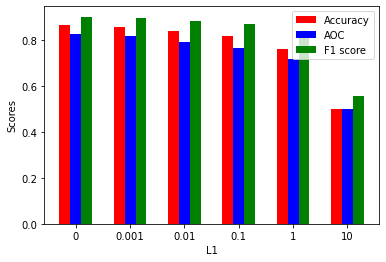

In [31]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = logistic_classifier( X,Y, (L1,0),learning_rate = 0.1, epochs = 10)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L1", x,accuracy, aread_under_curve, f1_score)

L2

Accuracy score: 0.827
AUC score: 0.773
F1 score: 0.877
Accuracy score: 0.804
AUC score: 0.751
F1 score: 0.860
Accuracy score: 0.845
AUC score: 0.802
F1 score: 0.887
Accuracy score: 0.843
AUC score: 0.803
F1 score: 0.884
Accuracy score: 0.788
AUC score: 0.749
F1 score: 0.843
Accuracy score: 0.551
AUC score: 0.548
F1 score: 0.610


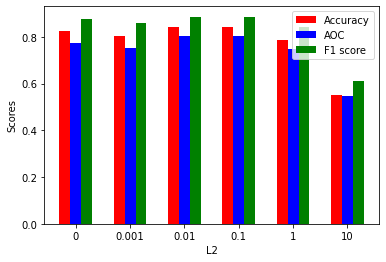

In [32]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = logistic_classifier( X,Y, (0,L2),learning_rate = 0.1, epochs = 10)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L2", x,accuracy, aread_under_curve, f1_score)

ElasticNet

Accuracy score: 0.856
AUC score: 0.816
F1 score: 0.894
Accuracy score: 0.827
AUC score: 0.775
F1 score: 0.876
Accuracy score: 0.832
AUC score: 0.782
F1 score: 0.879
Accuracy score: 0.808
AUC score: 0.758
F1 score: 0.861
Accuracy score: 0.769
AUC score: 0.711
F1 score: 0.836
Accuracy score: 0.538
AUC score: 0.535
F1 score: 0.598


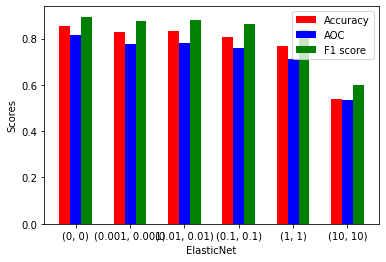

In [33]:
accuracy = []
aread_under_curve = []
f1_score = []
x = ((0,0), (0.001, 0.001),(0.01,0.01),(0.1,0.1),(1,1),(10,10))
for elastic in x:
    model = logistic_classifier( X,Y, elastic,learning_rate = 0.1, epochs = 10)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("ElasticNet", x,accuracy, aread_under_curve, f1_score)

## KNN

Accuracy score: 0.736
AUC score: 0.749
F1 score: 0.688
Accuracy score: 0.732
AUC score: 0.765
F1 score: 0.683
Accuracy score: 0.704
AUC score: 0.792
F1 score: 0.635
Accuracy score: 0.663
AUC score: 0.815
F1 score: 0.562


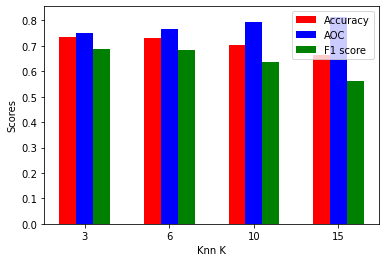

In [34]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (3,6,10,15)
for k in x:
    model = KNN( X,Y, k)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)


plot_graph("Knn K", x, accuracy, aread_under_curve, f1_score)

## Nieve Bayes

In [36]:
model = NeiveBayesModel( train_images,train_labels, bins = 28*28)
y_ = model.predict(test_images)
ab_metrics(test_labels,y_)

Accuracy score: 0.731
AUC score: 0.778
F1 score: 0.680


(0.7307692307692307, 0.7779476221783914, 0.6803970709715359)

## GMM

Accuracy score: 0.872
AUC score: 0.892
F1 score: 0.866
Accuracy score: 0.848
AUC score: 0.879
F1 score: 0.843
Accuracy score: 0.824
AUC score: 0.874
F1 score: 0.825
Accuracy score: 0.830
AUC score: 0.842
F1 score: 0.819


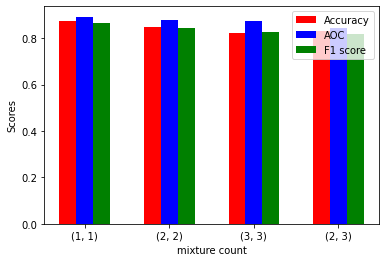

In [37]:
accuracy = []
aread_under_curve = []
f1_score = []
x = ((1,1),(2,2),(3,3),(2,3))
for each in x:
    model_0 = GMM( X[Y == 0], each[0])
    model_1 = GMM(X[Y == 1], each[1])
    a,b = np.unique(Y, return_counts = True)
    prior = np.log(b/np.sum(b))
    y_0 = model_0.log_probablity(X_) + prior[0]
    y_1 = model_1.log_probablity(X_) + prior[1]
    # print(y_0.shape, y_1.shape)
    y_ = scipy.special.softmax(np.c_[y_0.reshape(-1,1),y_1.reshape(-1,1)], axis = 1)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

plot_graph("mixture count", x,accuracy, aread_under_curve, f1_score)


## Fisher LDM

In [38]:
model = fisher_LDM( train_images,train_labels)
y_ = model.predict(test_images)
ab_metrics(test_labels,y_, printing = True)

Accuracy score: 0.780
AUC score: 0.707
F1 score: 0.851


(0.780448717948718, 0.7072649572649572, 0.8505997818974917)

## Bayes classifier with ML estimate with gaussian

In [39]:
model = Bayes_classifier_ML( train_images,train_labels)
y_ = model.predict(test_images)
ab_metrics(test_labels,y_, printing = True)

Accuracy score: 0.764
AUC score: 0.692
F1 score: 0.839


(0.7644230769230769, 0.6918803418803419, 0.8389923329682366)

## Parzen Window

Accuracy score: 0.625
AUC score: 0.500
F1 score: 0.481
Accuracy score: 0.625
AUC score: 0.500
F1 score: 0.481
Accuracy score: 0.625
AUC score: 0.500
F1 score: 0.481
Accuracy score: 0.625
AUC score: 0.500
F1 score: 0.481


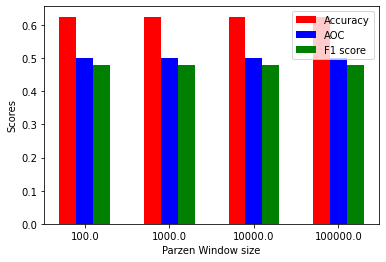

In [40]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (1e2,1e3,1e4,1e5)
for L in x:
    model = Bayes_classifier_Parzen( X,Y, L)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

plot_graph("Parzen Window size", x,accuracy, aread_under_curve, f1_score)

## SVM

In [48]:
from sklearn.decomposition import PCA
X = np.vstack((train_images,val_images))
Y = np.concatenate((train_labels,val_labels), axis = 0)

pca = PCA(50, whiten = True)
X = pca.fit_transform(X)
X_ = pca.transform(test_images)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

In [62]:
model = svm_model( X[:500],Y[:500], slack = 0.5, kernal= "linear" )
y_ = model.predict(X_)
ab_metrics(Y_,y_, printing = True)

my #support vector:  116
Accuracy score: 0.861
AUC score: 0.839
F1 score: 0.892


(0.8605769230769231, 0.8388888888888889, 0.892459826946848)

In [70]:
model = svm_model( X[:500],Y[:500], slack = 0.5, kernal= "gaussian" , gamma = 0.01)
y_ = model.predict(X_)
ab_metrics(Y_,y_, printing = True)

my #support vector:  269
Accuracy score: 0.795
AUC score: 0.728
F1 score: 0.858


(0.7948717948717948, 0.7282051282051283, 0.8584070796460177)

In [68]:
model = svm_model( X[:500],Y[:500], slack =1, kernal= "poly_kernal", degree = 2 , gamma = 1)
y_ = model.predict(X_)
ab_metrics(Y_,y_, printing = True)

my #support vector:  254
Accuracy score: 0.790
AUC score: 0.726
F1 score: 0.854


(0.7900641025641025, 0.726068376068376, 0.8539576365663322)

grid search

In [360]:
gamma = [1e-3,1e-2,1e-1,1,10]
slack = [0.1,1,10,50,100]
degree = [1,2,3,4]

In [363]:
gs = grid_search_svm(X[0:500,:],Y[0:500],X_,Y_[:], ab_metrics)
result1 = gs.gaussian(gamma, slack)
result2 = gs.polynomial(degree, slack)
result3 = gs.linear(slack)

RBF: slack(0.1) gamma(0.001) mectrics:Accuracy score: 0.846
AUC score: 0.910
F1 score: 0.847
--------------------
RBF: slack(0.1) gamma(0.01) mectrics:Accuracy score: 0.849
AUC score: 0.912
F1 score: 0.851
--------------------
RBF: slack(0.1) gamma(0.1) mectrics:Accuracy score: 0.851
AUC score: 0.890
F1 score: 0.852
--------------------
RBF: slack(0.1) gamma(1) mectrics:Accuracy score: 0.673
AUC score: 0.308
F1 score: 0.541
--------------------
RBF: slack(0.1) gamma(10) mectrics:Accuracy score: 0.673
AUC score: 0.500
F1 score: 0.541
--------------------
RBF: slack(1) gamma(0.001) mectrics:Accuracy score: 0.844
AUC score: 0.910
F1 score: 0.846
--------------------
RBF: slack(1) gamma(0.01) mectrics:Accuracy score: 0.869
AUC score: 0.921
F1 score: 0.868
--------------------
RBF: slack(1) gamma(0.1) mectrics:Accuracy score: 0.826
AUC score: 0.891
F1 score: 0.830
--------------------
RBF: slack(1) gamma(1) mectrics:Accuracy score: 0.673
AUC score: 0.277
F1 score: 0.541
--------------------

## Multi Layer Perceptron

In [289]:
from sklearn.decomposition import PCA
X = np.vstack((train_images,val_images))
Y = np.concatenate((train_labels,val_labels), axis = 0)

pca = PCA(75)
X = pca.fit_transform(X)
X_ = pca.transform(test_images)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

In [290]:
Y = one_hot_representer(Y)

hidden layer is softmax

In [291]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "sigmoid", \
                output_activation = "softmax", \
                loss_function = "cross_entropy_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

Accuracy score: 0.625
AUC score: 0.556
F1 score: 0.481


In [293]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "relu", \
                output_activation = "softmax", \
                loss_function = "cross_entropy_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

Accuracy score: 0.627
AUC score: 0.448
F1 score: 0.487


In [294]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "softmax", \
                output_activation = "softmax", \
                loss_function = "cross_entropy_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

Accuracy score: 0.625
AUC score: 0.515
F1 score: 0.481


In [295]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "sigmoid", \
                output_activation = "softmax", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

Accuracy score: 0.375
AUC score: 0.564
F1 score: 0.205


In [296]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "relu", \
                output_activation = "softmax", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

Accuracy score: 0.580
AUC score: 0.499
F1 score: 0.486


In [297]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "softmax", \
                output_activation = "softmax", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

Accuracy score: 0.375
AUC score: 0.373
F1 score: 0.205


In [ ]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 75, \
                hidden_layers=[70,50,25,10,5], num_outputs=2, \
                hidden_activation = "softmax", \
                output_activation = "relu", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)

# Dataset Two

Dataset loading and metric function    (  have used sklearn metrics to report honest results.  )

In [369]:
test_images = np.load('../PRNN_data/data_set_2/test_images.npy')
test_labels = np.load('../PRNN_data/data_set_2/test_labels.npy').flatten()
train_images = np.load('../PRNN_data/data_set_2/train_images.npy')
train_labels = np.load('../PRNN_data/data_set_2/train_labels.npy').flatten()
val_images = np.load('../PRNN_data/data_set_2/val_images.npy')
val_labels = np.load('../PRNN_data/data_set_2/val_labels.npy').flatten()

l = [train_images,train_labels,\
    val_images,val_labels,\
    test_images,test_labels]
for i in range(len(l)):
    k = l[i]
    print (k.shape)
del(l)

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import f1_score as f1
def ab_metrics(true_y, predicted_y,printing = True):
    if predicted_y.ndim > 1:
        temp = np.argmax(predicted_y, axis=1)
        temp2 = one_hot_representer(true_y)
        a1 = acc(true_y, temp,normalize=True)
        a2 = auc(temp2, predicted_y, multi_class = 'ovr')
        a3 = f1(true_y, temp,average = 'weighted')
    else:
        a1=acc(true_y, predicted_y,normalize=True)
        a2=auc(true_y, predicted_y)
        a3=f1(true_y, predicted_y)
    if printing:
        print("Accuracy score: {:.3f}".format(a1))
        print("AUC score: {:.3f}".format(a2))
        print("F1 score: {:.3f}".format(a3))
    return a1, a2, a3

(11959, 28, 28, 3)
(11959,)
(1712, 28, 28, 3)
(1712,)
(3421, 28, 28, 3)
(3421,)


In [370]:
X = np.vstack((train_images,val_images))
X = np.array(X).astype(float).reshape(-1,28*28*3)
X_ = np.array(test_images).astype(float).reshape(-1,28*28*3)
print(X.shape, X_.shape)

(13671, 2352) (3421, 2352)


In [371]:
from sklearn.decomposition import PCA
Y = np.concatenate((train_labels,val_labels), axis = 0)
test_images
pca = PCA(175, whiten  = True)
X = pca.fit_transform(X)
X_ = pca.transform(X_)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

## linear

### L1

Accuracy score: 0.704
AUC score: 0.931
F1 score: 0.685
Accuracy score: 0.701
AUC score: 0.931
F1 score: 0.680
Accuracy score: 0.669
AUC score: 0.923
F1 score: 0.623
Accuracy score: 0.436
AUC score: 0.717
F1 score: 0.344
Accuracy score: 0.140
AUC score: 0.514
F1 score: 0.141
Accuracy score: 0.148
AUC score: 0.540
F1 score: 0.151


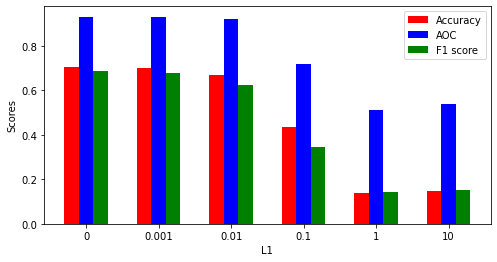

In [313]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = multi_class_linear_classifier( X,Y, (L1,0),learning_rate = 0.001, epochs = 50)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L1", x,accuracy, aread_under_curve, f1_score)

### L2

Accuracy score: 0.705
AUC score: 0.931
F1 score: 0.686
Accuracy score: 0.705
AUC score: 0.931
F1 score: 0.686
Accuracy score: 0.705
AUC score: 0.930
F1 score: 0.686
Accuracy score: 0.704
AUC score: 0.930
F1 score: 0.685
Accuracy score: 0.705
AUC score: 0.928
F1 score: 0.686
Accuracy score: 0.687
AUC score: 0.921
F1 score: 0.666


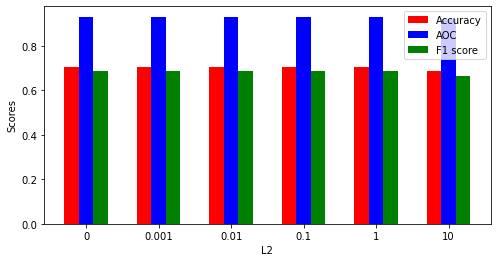

In [314]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = multi_class_linear_classifier( X,Y, (0,L2),learning_rate = 0.001, epochs = 50)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L2", x,accuracy, aread_under_curve, f1_score)

### Elastic Net

In [374]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    for L2 in x:
        model = multi_class_linear_classifier( X,Y, (L1,L2),learning_rate = 0.001, epochs = 50)
        y_ = model.predict(X_)
        a,b,c = ab_metrics(Y_,y_)
        accuracy.append(a)
        aread_under_curve.append(b)
        f1_score.append(c)


Accuracy score: 0.705
AUC score: 0.931
F1 score: 0.686
Accuracy score: 0.706
AUC score: 0.931
F1 score: 0.687
Accuracy score: 0.704
AUC score: 0.931
F1 score: 0.685
Accuracy score: 0.706
AUC score: 0.931
F1 score: 0.687
Accuracy score: 0.704
AUC score: 0.929
F1 score: 0.685
Accuracy score: 0.692
AUC score: 0.920
F1 score: 0.674
Accuracy score: 0.703
AUC score: 0.931
F1 score: 0.682
Accuracy score: 0.704
AUC score: 0.932
F1 score: 0.684
Accuracy score: 0.704
AUC score: 0.932
F1 score: 0.684
Accuracy score: 0.703
AUC score: 0.931
F1 score: 0.681
Accuracy score: 0.703
AUC score: 0.931
F1 score: 0.682
Accuracy score: 0.702
AUC score: 0.931
F1 score: 0.681
Accuracy score: 0.667
AUC score: 0.923
F1 score: 0.620
Accuracy score: 0.667
AUC score: 0.923
F1 score: 0.620
Accuracy score: 0.668
AUC score: 0.923
F1 score: 0.621
Accuracy score: 0.666
AUC score: 0.923
F1 score: 0.620
Accuracy score: 0.666
AUC score: 0.923
F1 score: 0.619
Accuracy score: 0.667
AUC score: 0.923
F1 score: 0.620
Accuracy s

## Logistic

### L1

Accuracy score: 0.783
AUC score: 0.954
F1 score: 0.782
Accuracy score: 0.784
AUC score: 0.955
F1 score: 0.782
Accuracy score: 0.782
AUC score: 0.955
F1 score: 0.780
Accuracy score: 0.765
AUC score: 0.951
F1 score: 0.761
Accuracy score: 0.620
AUC score: 0.901
F1 score: 0.562
Accuracy score: 0.200
AUC score: 0.498
F1 score: 0.137


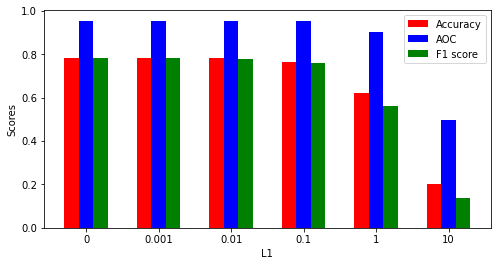

In [270]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = multi_class_logistic_classifier( X,Y, (L1,0),learning_rate = 0.001, epochs = 50)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L1", x,accuracy, aread_under_curve, f1_score)

### L2

Accuracy score: 0.783
AUC score: 0.954
F1 score: 0.782
Accuracy score: 0.783
AUC score: 0.954
F1 score: 0.782
Accuracy score: 0.781
AUC score: 0.954
F1 score: 0.779
Accuracy score: 0.761
AUC score: 0.951
F1 score: 0.756
Accuracy score: 0.722
AUC score: 0.939
F1 score: 0.710
Accuracy score: 0.684
AUC score: 0.914
F1 score: 0.668


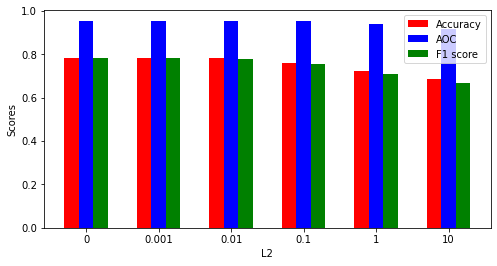

In [271]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = multi_class_logistic_classifier( X,Y, (0,L2),learning_rate = 0.001, epochs = 50)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)

plot_graph("L2", x,accuracy, aread_under_curve, f1_score)

### Elastic

In [278]:
accuracy = []
aread_under_curve = []
f1_score = []
x = []
for L1 in [0.01,0.1,1,5]:
    for L2 in [0.01,0.1,1,5]:
        print("------L1:{} , L2:{}-----".format(L1,L2))
        model = multi_class_logistic_classifier( X,Y, (L1,L2),learning_rate = 0.1, epochs = 10)
        y_ = model.predict(X_)
        a,b,c = ab_metrics(Y_,y_)
        accuracy.append(a)
        aread_under_curve.append(b)
        f1_score.append(c)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)


------L1:0.01 , L2:0.01-----
Accuracy score: 0.680
AUC score: 0.882
F1 score: 0.675
------L1:0.01 , L2:0.1-----
Accuracy score: 0.686
AUC score: 0.885
F1 score: 0.684
------L1:0.01 , L2:1-----
Accuracy score: 0.674
AUC score: 0.884
F1 score: 0.671
------L1:0.01 , L2:5-----
Accuracy score: 0.673
AUC score: 0.881
F1 score: 0.668
------L1:0.1 , L2:0.01-----
Accuracy score: 0.622
AUC score: 0.864
F1 score: 0.615
------L1:0.1 , L2:0.1-----
Accuracy score: 0.617
AUC score: 0.856
F1 score: 0.614
------L1:0.1 , L2:1-----
Accuracy score: 0.614
AUC score: 0.862
F1 score: 0.610
------L1:0.1 , L2:5-----
Accuracy score: 0.591
AUC score: 0.852
F1 score: 0.582
------L1:1 , L2:0.01-----
Accuracy score: 0.432
AUC score: 0.751
F1 score: 0.415
------L1:1 , L2:0.1-----
Accuracy score: 0.438
AUC score: 0.731
F1 score: 0.398
------L1:1 , L2:1-----
Accuracy score: 0.447
AUC score: 0.770
F1 score: 0.430
------L1:1 , L2:5-----
Accuracy score: 0.414
AUC score: 0.751
F1 score: 0.406
------L1:5 , L2:0.01-----
Acc

## KNN 

Accuracy score: 0.377
AUC score: 0.648
F1 score: 0.348
Accuracy score: 0.353
AUC score: 0.729
F1 score: 0.306
Accuracy score: 0.328
AUC score: 0.777
F1 score: 0.286
Accuracy score: 0.298
AUC score: 0.807
F1 score: 0.253
Accuracy score: 0.269
AUC score: 0.825
F1 score: 0.217
Accuracy score: 0.251
AUC score: 0.840
F1 score: 0.197


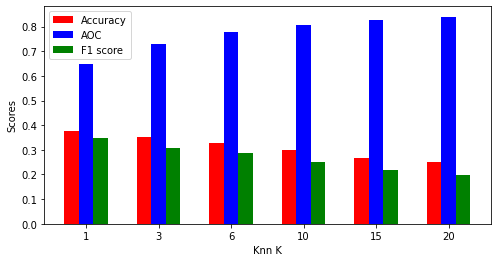

In [273]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (1,3,6,10,15,20)
for k in x:
    model = KNN( X,Y, k)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

plot_graph("Knn K", x,accuracy, aread_under_curve, f1_score)

## Fisher LdM

In [274]:
model = multi_fisher_LDM( X,Y)
probabilities = model.predict(X_)
ab_metrics(Y_,probabilities, printing = True)

Accuracy score: 0.574
AUC score: 0.851
F1 score: 0.620


(0.5735165156387021, 0.8507143146060914, 0.6200806298051609)

## Parzen Window

Accuracy score: 0.195
AUC score: 0.500
F1 score: 0.063
Accuracy score: 0.195
AUC score: 0.500
F1 score: 0.063
Accuracy score: 0.195
AUC score: 0.500
F1 score: 0.063
Accuracy score: 0.195
AUC score: 0.500
F1 score: 0.063


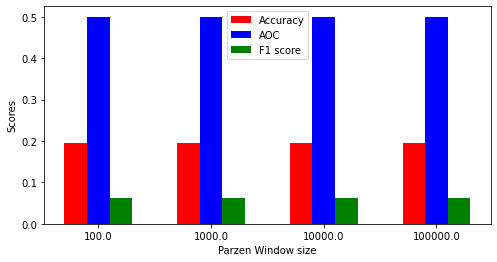

In [277]:
accuracy = []
aread_under_curve = []
f1_score = []
x = (1e2,1e3,1e4,1e5)

for L in x:
    model = Bayes_classifier_Parzen( X,Y, L)
    y_ = model.predict(X_)
    a,b,c = ab_metrics(Y_,y_)
    accuracy.append(a)
    aread_under_curve.append(b)
    f1_score.append(c)

plot_graph("Parzen Window size", x,accuracy, aread_under_curve, f1_score)

## Byes with MLE Gauassian

In [ ]:
model = Bayes_classifier_ML( X,Y)
probabilities = model.predict(X_)
ab_metrics(Y_,probabilities, printing = True)

Accuracy score: 0.672
AUC score: 0.500
F1 score: 0.541


(0.6723963599595552, 0.4996243425995492, 0.5410880018779732)

## SVM model

In [ ]:
from sklearn.decomposition import PCA
X = np.vstack((train_images,val_images))
Y = np.concatenate((train_labels,val_labels), axis = 0)

pca = PCA(50, whiten = True)
X = pca.fit_transform(X)
X_ = pca.transform(test_images)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

In [ ]:
model = multi_class_svm( X[:500],Y[:500], slack = 0.5, kernal= "linear" )
y_ = model.predict(X_)
ab_metrics(Y_,y_, printing = True)

my #support vector:  106
my #support vector:  219
my #support vector:  110
my #support vector:  185
my #support vector:  100
my #support vector:  130
my #support vector:  150
my #support vector:  64
Accuracy score: 0.381
AUC score: 0.747
F1 score: 0.332


(0.38146740719087985, 0.7466469910706433, 0.3323533587747764)

In [368]:
model = multi_class_svm( X[:500],Y[:500], slack = 0.5, kernal= "gaussian" , gamma = 0.01)
y_ = model.predict(X_)
ab_metrics(Y_,y_, printing = True)

my #support vector:  445
my #support vector:  464
my #support vector:  446
my #support vector:  483
my #support vector:  420
my #support vector:  447
my #support vector:  432
my #support vector:  126
Accuracy score: 0.096
AUC score: 0.523
F1 score: 0.051


(0.09558608593978368, 0.5229952243143695, 0.050814648281820314)

In [ ]:
model = multi_class_svm( X[:500],Y[:500], slack = 0.5, kernal= "poly_kernal" , gamma = 1, degree = 4)
y_ = model.predict(X_)
ab_metrics(Y_,y_, printing = True)

MUlti Layer Perceptron

In [ ]:
# Y = one_hot_representer(Y)
# shfl = np.random.permutation(X.shape[0])
# X = X[shfl]
# Y = Y[shfl]

# model = MLP(X, Y, epochs = 10, learning_rate = 0.001 ,num_inputs = 200, \
#                 hidden_layers=[150, 100, 50, 25, 10], num_outputs=8, \
#                 hidden_activation = "softmax", \
#                 output_activation = "softmax", \
#                 loss_function = "cross_entropy_loss")
# y_ = model.predict(X_)
a,b,c = ab_metrics(Y_,y_)
d_metric(Y_,y_)

In [148]:
y_.shape

(3421,)

# Dataset Three
### Running all models on it

Dataset loading and metric function    (  have used sklearn metrics to report honest results.  )

In [315]:
test_images = np.load('../PRNN_data/data_set_3/test_images.npy')
test_labels = np.load('../PRNN_data/data_set_3/test_labels.npy')
train_images = np.load('../PRNN_data/data_set_3/train_images.npy')
train_labels = np.load('../PRNN_data/data_set_3/train_labels.npy')
val_images = np.load('../PRNN_data/data_set_3/val_images.npy')
val_labels = np.load('../PRNN_data/data_set_3/val_labels.npy')

train_images = train_images.reshape(train_images.shape[0], -1)
val_images = val_images.reshape(val_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

train_images = np.vstack((train_images, val_images)).astype(float)
train_labels = np.vstack((train_labels, val_labels)).astype(float)

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
def c_metric(true_y, predicted_y, printing = True):
    a = mse(true_y, predicted_y)
    b = mae(true_y, predicted_y)
    if printing:
        print("MSE score: ", a)
        print("MAE score: ", b)
    return a, b

In [316]:
train_images.shape

(701, 90000)

In [317]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
pca = PCA(100, whiten = True)
train_images = pca.fit_transform(train_images)
train_images = sc.fit_transform(train_images)


test_images = pca.transform(test_images)
test_images = sc.transform(test_images)

L1

MSE score:  2128.3261115538266
MAE score:  34.36016840381236
MSE score:  2128.9660619131287
MAE score:  34.40862932883756
MSE score:  2129.2600968642437
MAE score:  34.39055398892565
MSE score:  2123.519267909819
MAE score:  34.3977747176274
MSE score:  2071.507290606167
MAE score:  34.128627993915174
MSE score:  2222.3080484729335
MAE score:  35.592997100271546


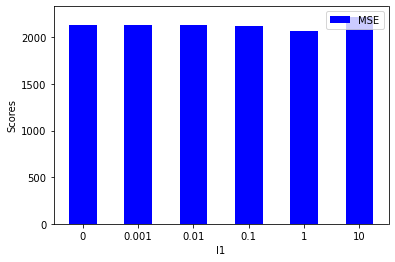

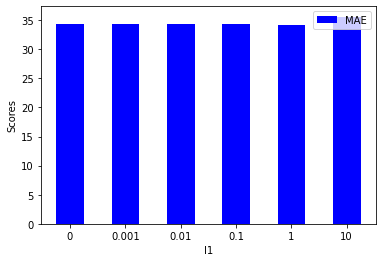

In [193]:
MSE = []
MAE = []
x = x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = vector_valued_linear_regression(train_images,train_labels,regulariser_value=(L1,0),learning_rate = 0.01, epochs = 50)
    y_ = model.predict(test_images)
    a,b = c_metric(test_labels,y_)
    MSE.append(a)
    MAE.append(b)

x_axis = np.arange(len(x))
width = 0.5
plt.bar(x_axis, MSE, width, color='blue')
plt.xlabel("l1")
plt.ylabel("Scores")
plt.xticks(x_axis, x)
plt.legend(["MSE"])
plt.show()

plt.bar(x_axis, MAE, width, color='blue')
plt.xlabel("l1")
plt.legend(["MAE"])
plt.ylabel("Scores")
plt.xticks(x_axis, x)
plt.legend(["MAE"])
plt.show()

L2

MSE score:  2133.35466648249
MAE score:  34.439802717415475
MSE score:  2136.507933516296
MAE score:  34.42692966873611
MSE score:  2136.4664142028864
MAE score:  34.40929244732956
MSE score:  2311.062270987643
MAE score:  35.593227417889985
MSE score:  6795.026467854195
MAE score:  70.47179063983835
MSE score:  18474.274492887682
MAE score:  125.84386077658164


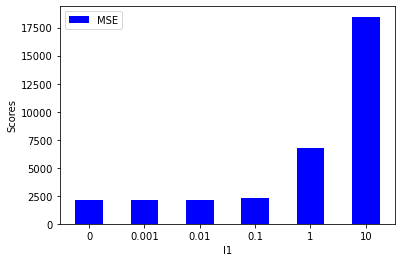

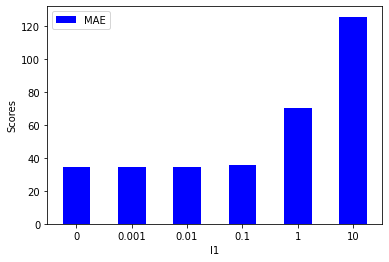

In [194]:
MSE = []
MAE = []
x = x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = vector_valued_linear_regression(train_images,train_labels,regulariser_value=(0,L2),learning_rate = 0.01, epochs = 50)
    y_ = model.predict(test_images)
    a,b = c_metric(test_labels,y_)
    MSE.append(a)
    MAE.append(b)

x_axis = np.arange(len(x))
width = 0.5
plt.bar(x_axis, MSE, width, color='blue')
plt.xlabel("l1")
plt.ylabel("Scores")
plt.xticks(x_axis, x)
plt.legend(["MSE"])
plt.show()

plt.bar(x_axis, MAE, width, color='blue')
plt.xlabel("l1")
plt.legend(["MAE"])
plt.ylabel("Scores")
plt.xticks(x_axis, x)
plt.legend(["MAE"])
plt.show()

### Elastic

In [318]:
MSE = []
MAE = []
x = x = (0, 0.01,0.1,1,10)
for L1 in x:
    for L2 in x:
        model = vector_valued_linear_regression(train_images,train_labels,regulariser_value=(L1,L2),learning_rate = 0.01, epochs = 50)
        y_ = model.predict(test_images)
        a,b = c_metric(test_labels,y_)
        MSE.append(a)
        MAE.append(b)

MSE score:  2089.698354042558
MAE score:  34.19018552413852
MSE score:  2100.022772864449
MAE score:  34.21115317518419
MSE score:  2267.6419298489923
MAE score:  35.51280749794127
MSE score:  6789.200318394742
MAE score:  70.51120027392011
MSE score:  18475.387942480666
MAE score:  125.83424764917382
MSE score:  2094.3474575018886
MAE score:  34.204926050985435
MSE score:  2091.9483822865827
MAE score:  34.21493580273596
MSE score:  2085.558694131598
MAE score:  34.22179012199802
MSE score:  2091.206927558409
MAE score:  34.225740010547874
MSE score:  2085.657111600978
MAE score:  34.179797097799764
MSE score:  2085.9306486636324
MAE score:  34.17335899153699
MSE score:  2081.154236446153
MAE score:  34.157299891312576
MSE score:  2083.020276731093
MAE score:  34.160301645014044
MSE score:  2081.875936610291
MAE score:  34.15589303107106
MSE score:  2084.6637891217197
MAE score:  34.16197310211974
MSE score:  2045.8014537671484
MAE score:  33.927396054127136
MSE score:  2054.339717744

# Dataset Four
## Running all models on it

Dataset loading and metric function    (  have used sklearn metrics to report honest results.  )

In [349]:
test_data = np.load('../PRNN_data/data_set_4/test_data.npy')
test_labels = np.load('../PRNN_data/data_set_4/test_labels.npy')
train_data = np.load('../PRNN_data/data_set_4/train_data.npy')
train_labels = np.load('../PRNN_data/data_set_4/train_labels.npy')
val_data = np.load('../PRNN_data/data_set_4/val_data.npy')
val_labels = np.load('../PRNN_data/data_set_4/val_labels.npy')

from sklearn.metrics import confusion_matrix
def d_metric(true_y, predicted_y, printing = True):
    if predicted_y.ndim > 1:
        predicted_y = np.argmax(predicted_y, axis=1)
    tn,fp,fn,tp = confusion_matrix(true_y, predicted_y, normalize = 'true').ravel()
    N = true_y.size
    tn = tn
    fp = fp
    fn = fn
    tp = tp
    if printing:
        print("true postive = ", tp)
        print("true negative = ", tn)
        print("False postive = ", fp)
        print("False negative = ", fn)
    return tn,fp,fn,tp

def plot_graph(x_name, x,tn, fp, fn, tp):
    x_axis = np.arange(len(x))
    width = 0.1
    plt.bar(x_axis-0.1, tn, width, color='red')
    plt.bar(x_axis, fp, width, color='blue')
    plt.bar(x_axis+0.1, fn, width, color='purple')
    plt.bar(x_axis+0.2, tp, width, color='green')
    plt.xlabel(x_name)
    plt.ylabel("Scores")
    plt.xticks(x_axis, x)
    plt.legend(["tn", "fp", "fn", "tp"])
    plt.show()

In [350]:
from sklearn.decomposition import PCA
X = np.vstack((train_data,val_data))
Y = np.concatenate((train_labels,val_labels), axis = 0)
pca = PCA(50, whiten = True)
X = pca.fit_transform(X)
X_ = pca.transform(test_data)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

## Linear

L1

true postive =  0.8075734157650696
true negative =  0.891435011269722
False postive =  0.10856498873027799
False negative =  0.19242658423493045
true postive =  0.7990726429675425
true negative =  0.8951915852742299
False postive =  0.1048084147257701
False negative =  0.2009273570324575
true postive =  0.8021638330757341
true negative =  0.8895567242674681
False postive =  0.11044327573253193
False negative =  0.19783616692426584
true postive =  0.2635239567233385
true negative =  0.9763335837716003
False postive =  0.0236664162283997
False negative =  0.7364760432766615
true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
true postive =  0.1035548686244204
true negative =  0.9361382419233659
False postive =  0.0638617580766341
False negative =  0.8964451313755796


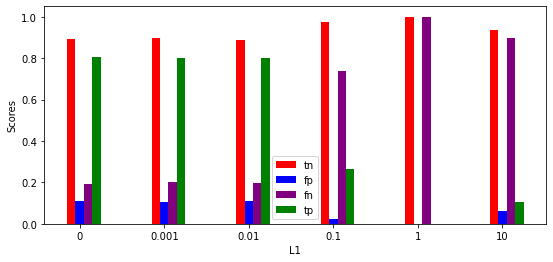

In [337]:
tn = []
fp = []
fn = []
tp = []
plt.rcParams["figure.figsize"] = (9,4)
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = linear_classifier( X,Y, (L1,0),learning_rate = 0.01, epochs = 50)
    y_ = model.predict(X_)
    a,b,c,d = d_metric(Y_,y_)
    tn.append(a)
    fp.append(b)
    fn.append(c)
    tp.append(d)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)
plot_graph("L1", x,tn, fp, fn, tp)

L2 

true postive =  0.8230293663060279
true negative =  0.8891810668670173
False postive =  0.11081893313298272
False negative =  0.17697063369397217
true postive =  0.8183925811437404
true negative =  0.8891810668670173
False postive =  0.11081893313298272
False negative =  0.18160741885625967
true postive =  0.8160741885625966
true negative =  0.891435011269722
False postive =  0.10856498873027799
False negative =  0.1839258114374034
true postive =  0.7627511591962906
true negative =  0.9102178812922614
False postive =  0.08978211870773854
False negative =  0.23724884080370942
true postive =  0.10973724884080371
true negative =  0.9951164537941397
False postive =  0.004883546205860256
False negative =  0.8902627511591963
true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0


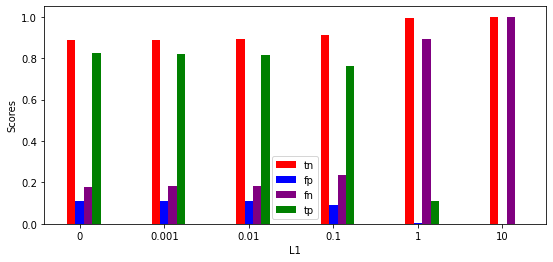

In [338]:
tn = []
fp = []
fn = []
tp = []
plt.rcParams["figure.figsize"] = (9,4)
x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = linear_classifier( X,Y, (0,L2),learning_rate = 0.001, epochs = 50)
    y_ = model.predict(X_)
    a,b,c,d = d_metric(Y_,y_)
    tn.append(a)
    fp.append(b)
    fn.append(c)
    tp.append(d)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)
plot_graph("L1", x,tn, fp, fn, tp)

Elastic 

In [344]:
plt.rcParams["figure.figsize"] = (9,4)
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    for L2 in x:
        model = linear_classifier( X,Y, (L1,L2),learning_rate = 0.001, epochs = 50)
        y_ = model.predict(X_)
        ab_metrics(Y_,y_)

Accuracy score: 0.867
AUC score: 0.855
F1 score: 0.801
Accuracy score: 0.867
AUC score: 0.855
F1 score: 0.801
Accuracy score: 0.867
AUC score: 0.853
F1 score: 0.800
Accuracy score: 0.862
AUC score: 0.837
F1 score: 0.784
Accuracy score: 0.704
AUC score: 0.550
F1 score: 0.190
Accuracy score: 0.673
AUC score: 0.500
F1 score: 0.000
Accuracy score: 0.865
AUC score: 0.852
F1 score: 0.798
Accuracy score: 0.866
AUC score: 0.853
F1 score: 0.799
Accuracy score: 0.865
AUC score: 0.852
F1 score: 0.798
Accuracy score: 0.865
AUC score: 0.852
F1 score: 0.798
Accuracy score: 0.865
AUC score: 0.852
F1 score: 0.798
Accuracy score: 0.866
AUC score: 0.853
F1 score: 0.799
Accuracy score: 0.857
AUC score: 0.838
F1 score: 0.782
Accuracy score: 0.859
AUC score: 0.839
F1 score: 0.784
Accuracy score: 0.858
AUC score: 0.839
F1 score: 0.783
Accuracy score: 0.857
AUC score: 0.838
F1 score: 0.782
Accuracy score: 0.857
AUC score: 0.837
F1 score: 0.781
Accuracy score: 0.858
AUC score: 0.839
F1 score: 0.784
Accuracy s

## Logistic

L1

true postive =  0.8114374034003091
true negative =  0.8906836964688204
False postive =  0.10931630353117956
False negative =  0.18856259659969088
true postive =  0.8060278207109737
true negative =  0.8906836964688204
False postive =  0.10931630353117956
False negative =  0.19397217928902627
true postive =  0.8268933539412674
true negative =  0.8846731780616078
False postive =  0.11532682193839218
False negative =  0.1731066460587326
true postive =  0.8098918083462133
true negative =  0.8880540946656649
False postive =  0.11194590533433509
False negative =  0.1901081916537867
true postive =  0.7650695517774343
true negative =  0.8797896318557475
False postive =  0.12021036814425244
False negative =  0.23493044822256567
true postive =  0.4420401854714065
true negative =  0.5672426746806912
False postive =  0.43275732531930877
False negative =  0.5579598145285936


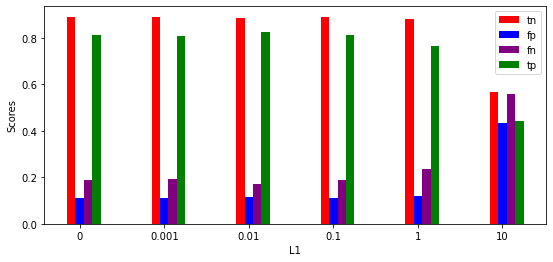

In [200]:
tn = []
fp = []
fn = []
tp = []
plt.rcParams["figure.figsize"] = (9,4)
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    model = logistic_classifier( X,Y, (L1,0),learning_rate = 0.01, epochs = 50)
    y_ = model.predict(X_)
    a,b,c,d = d_metric(Y_,y_)
    tn.append(a)
    fp.append(b)
    fn.append(c)
    tp.append(d)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)
plot_graph("L1", x,tn, fp, fn, tp)

L2

true postive =  0.8029366306027821
true negative =  0.891435011269722
False postive =  0.10856498873027799
False negative =  0.19706336939721794
true postive =  0.8114374034003091
true negative =  0.8820435762584523
False postive =  0.1179564237415477
False negative =  0.18856259659969088
true postive =  0.8284389489953632
true negative =  0.8801652892561983
False postive =  0.11983471074380166
False negative =  0.17156105100463678
true postive =  0.8183925811437404
true negative =  0.8812922614575507
False postive =  0.11870773854244929
False negative =  0.18160741885625967
true postive =  0.8253477588871716
true negative =  0.8715251690458302
False postive =  0.1284748309541698
False negative =  0.17465224111282843
true postive =  0.776661514683153
true negative =  0.873779113448535
False postive =  0.12622088655146507
False negative =  0.223338485316847


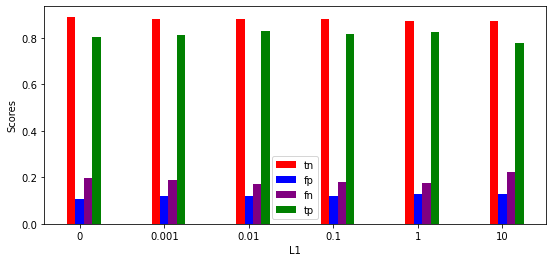

In [201]:
tn = []
fp = []
fn = []
tp = []
plt.rcParams["figure.figsize"] = (9,4)
x = (0, 0.001,0.01,0.1,1,10)
for L2 in x:
    model = logistic_classifier( X,Y, (0,L2),learning_rate = 0.01, epochs = 50)
    y_ = model.predict(X_)
    a,b,c,d = d_metric(Y_,y_)
    tn.append(a)
    fp.append(b)
    fn.append(c)
    tp.append(d)

# print(accuracy, "\n",aread_under_curve,"\n" ,f1_score)
plot_graph("L1", x,tn, fp, fn, tp)

Elastic

In [348]:
plt.rcParams["figure.figsize"] = (9,4)
x = (0, 0.001,0.01,0.1,1,10)
for L1 in x:
    for L2 in x:
        model = logistic_classifier( X,Y, (L1,L2),learning_rate = 0.001, epochs = 50)
        y_ = model.predict(X_)
        ab_metrics(Y_,y_)

Accuracy score: 0.845
AUC score: 0.798
F1 score: 0.888
Accuracy score: 0.841
AUC score: 0.794
F1 score: 0.886
Accuracy score: 0.845
AUC score: 0.798
F1 score: 0.888
Accuracy score: 0.848
AUC score: 0.801
F1 score: 0.890
Accuracy score: 0.853
AUC score: 0.807
F1 score: 0.894
Accuracy score: 0.848
AUC score: 0.802
F1 score: 0.890
Accuracy score: 0.843
AUC score: 0.796
F1 score: 0.887
Accuracy score: 0.841
AUC score: 0.794
F1 score: 0.886
Accuracy score: 0.845
AUC score: 0.798
F1 score: 0.888
Accuracy score: 0.843
AUC score: 0.796
F1 score: 0.887
Accuracy score: 0.843
AUC score: 0.796
F1 score: 0.887
Accuracy score: 0.845
AUC score: 0.798
F1 score: 0.888
Accuracy score: 0.841
AUC score: 0.794
F1 score: 0.886
Accuracy score: 0.841
AUC score: 0.794
F1 score: 0.886
Accuracy score: 0.845
AUC score: 0.798
F1 score: 0.888
Accuracy score: 0.841
AUC score: 0.794
F1 score: 0.886
Accuracy score: 0.846
AUC score: 0.799
F1 score: 0.889
Accuracy score: 0.841
AUC score: 0.794
F1 score: 0.886
Accuracy s

## KNN

true postive =  0.8091190108191654
true negative =  0.9094665664913599
False postive =  0.09053343350864013
False negative =  0.19088098918083463
true postive =  0.7248840803709428
true negative =  0.9410217881292261
False postive =  0.05897821187077385
False negative =  0.2751159196290572
true postive =  0.758887171561051
true negative =  0.9387678437265214
False postive =  0.06123215627347859
False negative =  0.241112828438949
true postive =  0.8052550231839258
true negative =  0.9301277235161532
False postive =  0.06987227648384674
False negative =  0.1947449768160742


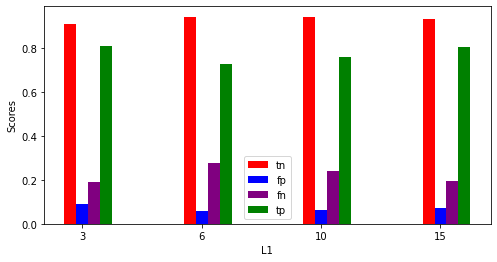

In [203]:
tn = []
fp = []
fn = []
tp = []
plt.rcParams["figure.figsize"] = (8,4)
x = (3,6,10,15)
for k in x:
    model = KNN( X,Y, k)
    y_ = model.predict(X_)
    a,b,c,d = d_metric(Y_,y_)
    tn.append(a)
    fp.append(b)
    fn.append(c)
    tp.append(d)

plot_graph("L1", x,tn, fp, fn, tp)

## GMM

In [213]:
x = [(1,1),(2,2),(2,3)]
for each in x:
    model_0 = GMM( X[Y == 0], each[0], iterations = 100)
    model_1 = GMM( X[Y == 1], each[1], iterations = 100)
    a,b = np.unique(Y, return_counts = True)
    prior = np.log(b/np.sum(b))
    y_0 = model_0.log_probablity(X_) + prior[0]
    y_1 = model_1.log_probablity(X_) + prior[1]
    y_ = scipy.special.softmax(np.c_[y_0.reshape(-1,1),y_1.reshape(-1,1)], axis = 1)
    a,b,c,d = d_metric(Y_,y_,printing = True)

true postive =  0.857032457496136
true negative =  0.8459804658151766
False postive =  0.15401953418482345
False negative =  0.14296754250386398
true postive =  0.8245749613601236
true negative =  0.2543200601051841
False postive =  0.745679939894816
False negative =  0.17542503863987635
true postive =  0.07187017001545595
true negative =  0.992862509391435
False postive =  0.007137490608564989
False negative =  0.9281298299845441


## Fisher LDM

In [215]:
model = multi_fisher_LDM( X,Y)
probabilities = model.predict(X_)
d_metric(Y_,probabilities, printing = True)

true postive =  0.8044822256568779
true negative =  0.8936889556724268
False postive =  0.10631104432757325
False negative =  0.1955177743431221


(0.8936889556724268,
 0.10631104432757325,
 0.1955177743431221,
 0.8044822256568779)

## Baye's with gaussian MLE

In [216]:
model = Bayes_classifier_ML( X,Y)
probabilities = model.predict(X_)
d_metric(Y_,probabilities, printing = True)

true postive =  0.857032457496136
true negative =  0.8459804658151766
False postive =  0.15401953418482345
False negative =  0.14296754250386398


(0.8459804658151766,
 0.15401953418482345,
 0.14296754250386398,
 0.857032457496136)

## Parzen Window

true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0


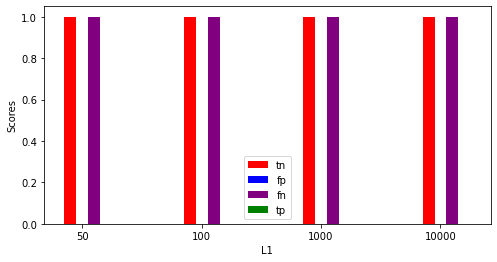

In [358]:
from sklearn.decomposition import PCA
X = np.vstack((train_data,val_data))
Y = np.concatenate((train_labels,val_labels), axis = 0)
pca = PCA(50, whiten = True)
X = pca.fit_transform(X)
X_ = pca.transform(test_data)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels


tn = []
fp = []
fn = []
tp = []
plt.rcParams["figure.figsize"] = (8,4)
x = (50,100,1000,10000)
for k in x:
    model = Bayes_classifier_Parzen( X,Y, k)
    y_ = model.predict(X_)
    a,b,c,d = d_metric(Y_,y_)
    tn.append(a)
    fp.append(b)
    fn.append(c)
    tp.append(d)

plot_graph("L1", x,tn, fp, fn, tp)

## SVM Model

In [217]:
from sklearn.decomposition import PCA
X = np.vstack((train_data,val_data))
Y = np.concatenate((train_labels,val_labels), axis = 0)

pca = PCA(50, whiten = True)
X = pca.fit_transform(X)
X_ = pca.transform(test_data)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_ = sc.transform(X_)
Y_ = test_labels

In [218]:
model = svm_model( X[:500],Y[:500], slack = 0.5, kernal= "linear" )
y_ = model.predict(X_)
d_metric(Y_,y_, printing = True)

my #support vector:  195
true postive =  0.9034003091190108
true negative =  0.6803155522163786
False postive =  0.3196844477836213
False negative =  0.09659969088098919


(0.6803155522163786,
 0.3196844477836213,
 0.09659969088098919,
 0.9034003091190108)

In [219]:
model = svm_model( X[:500],Y[:500], slack = 0.5, kernal= "gaussian" , gamma = 0.01)
y_ = model.predict(X_)
d_metric(Y_,y_, printing = True)

my #support vector:  326
true postive =  0.624420401854714
true negative =  0.9440270473328325
False postive =  0.05597295266716754
False negative =  0.3755795981452859


(0.9440270473328325,
 0.05597295266716754,
 0.3755795981452859,
 0.624420401854714)

In [220]:
model = svm_model( X[:500],Y[:500], slack =1, kernal= "poly_kernal", degree = 2 , gamma = 1)
y_ = model.predict(X_)
d_metric(Y_,y_, printing = True)

my #support vector:  298
true postive =  0.634466769706337
true negative =  0.8673929376408716
False postive =  0.13260706235912847
False negative =  0.3655332302936631


(0.8673929376408716,
 0.13260706235912847,
 0.3655332302936631,
 0.634466769706337)

In [221]:
gamma = [1e-3,1e-2,1e-1,1,10]
slack = [1,10,100]
degree = [1,2,3,4]

gs = grid_search_svm(X[0:500,:],Y[0:500],X_,Y_[:], d_metric)
result1 = gs.gaussian(gamma, slack)
result2 = gs.polynomial(degree, slack)
result3 = gs.linear(slack)

RBF: slack(1) gamma(0.001) mectrics:true postive =  0.8029366306027821
true negative =  0.8651389932381668
False postive =  0.1348610067618332
False negative =  0.19706336939721794
--------------------
RBF: slack(1) gamma(0.01) mectrics:true postive =  0.8091190108191654
true negative =  0.8989481592787378
False postive =  0.1010518407212622
False negative =  0.19088098918083463
--------------------
RBF: slack(1) gamma(0.1) mectrics:true postive =  0.38098918083462135
true negative =  0.9507888805409467
False postive =  0.04921111945905334
False negative =  0.6190108191653787
--------------------
RBF: slack(1) gamma(1) mectrics:true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
--------------------
RBF: slack(1) gamma(10) mectrics:true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
--------------------
RBF: slack(10) gamma(0.001) mectrics:true postive =  0.7828438948995363
true negative =  0.9034560480841473
False postive

## Multi layer Perceptron

In [222]:
Y = one_hot_representer(Y)

In [231]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X[:500], Y[:500], epochs =10, learning_rate = 0.01 ,num_inputs = 50, \
                hidden_layers=[30,30,15,5], num_outputs=2, \
                hidden_activation = "sigmoid", \
                output_activation = "softmax", \
                loss_function = "cross_entropy_loss")
y_ = model.predict(X_)
d_metric(Y_,y_)
a,b,c = ab_metrics(Y_,y_)

true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
Accuracy score: 0.673
AUC score: 0.540
F1 score: 0.541


In [232]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X[:500], Y[:500], epochs =10, learning_rate = 0.01 ,num_inputs = 50, \
                hidden_layers=[30,15,5], num_outputs=2, \
                hidden_activation = "relu", \
                output_activation = "softmax", \
                loss_function = "cross_entropy_loss")
y_ = model.predict(X_)
d_metric(Y_,y_)
a,b,c = ab_metrics(Y_,y_)

true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
Accuracy score: 0.673
AUC score: 0.486
F1 score: 0.541


In [233]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X[:500], Y[:500], epochs =10, learning_rate = 0.01 ,num_inputs = 50, \
                hidden_layers=[30,15,5], num_outputs=2, \
                hidden_activation = "softmax", \
                output_activation = "softmax", \
                loss_function = "cross_entropy_loss")
y_ = model.predict(X_)
d_metric(Y_,y_)
a,b,c = ab_metrics(Y_,y_)

true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
Accuracy score: 0.673
AUC score: 0.453
F1 score: 0.541


In [234]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X[:500], Y[:500], epochs =10, learning_rate = 0.01 ,num_inputs = 50, \
                hidden_layers=[30,15,5], num_outputs=2, \
                hidden_activation = "sigmoid", \
                output_activation = "softmax", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
d_metric(Y_,y_)
a,b,c = ab_metrics(Y_,y_)

true postive =  1.0
true negative =  0.0
False postive =  1.0
False negative =  0.0
Accuracy score: 0.327
AUC score: 0.532
F1 score: 0.161


In [235]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X[:500], Y[:500], epochs =10, learning_rate = 0.01 ,num_inputs = 50, \
                hidden_layers=[30,15,5], num_outputs=2, \
                hidden_activation = "relu", \
                output_activation = "softmax", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
d_metric(Y_,y_)
a,b,c = ab_metrics(Y_,y_)

true postive =  0.0
true negative =  1.0
False postive =  0.0
False negative =  1.0
Accuracy score: 0.673
AUC score: 0.525
F1 score: 0.541


In [237]:
shfl = np.random.permutation(X.shape[0])
X = X[shfl]
Y = Y[shfl]

model = MLP(X[:500], Y[:500], epochs =10, learning_rate = 0.01 ,num_inputs = 50, \
                hidden_layers=[30,15,5], num_outputs=2, \
                hidden_activation = "softmax", \
                output_activation = "softmax", \
                loss_function = "squared_loss")
y_ = model.predict(X_)
d_metric(Y_,y_)
a,b,c = ab_metrics(Y_,y_)

true postive =  1.0
true negative =  0.0
False postive =  1.0
False negative =  0.0
Accuracy score: 0.327
AUC score: 0.496
F1 score: 0.161
